In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict

In [2]:
dataset = 'cifar100'
architecture = 'ResNet20-4'

results_folder = '../ATSRefactored/results'
folder_name = f"data_{dataset}_arch_{architecture}"

# Individual scores

In [3]:
results = []

accuracy_folder = results_folder+'/accuracy/'+folder_name+'/'
reconstruction_folder = results_folder+'/reconstruction/'+folder_name+'/'

pols, accs, recons, ids = [], [], [], []
special_pols, special_accs, special_recons, special_ids = [], [], [], []

special = ["3-1-7",
        "43-18-18"]

for i, filename in enumerate(os.listdir(accuracy_folder)):
    policy_name = filename.split(".npy")[0]
    
    acc_scores = np.load(accuracy_folder+filename).tolist()
    acc_mean = np.mean(acc_scores)
    
    recon_scores = np.load(reconstruction_folder+filename).tolist()
    recon_mean = np.mean(recon_scores)
    
    if acc_mean < -150:
        continue
    
    if policy_name in special:       
        special_pols.append(policy_name)
        special_accs.append(acc_mean)
        special_recons.append(recon_mean)
        special_ids.append(i)
    else:
        pols.append(policy_name)
        accs.append(acc_mean)
        recons.append(recon_mean)
        ids.append(i)

In [4]:
# fig, ax = plt.subplots(figsize=(12, 4))

# ax.bar(x=ids, height=accs, color="grey")
# ax.bar(x=special_ids, height=special_accs, color="orange")

# ax.set_ylim(0, -100)

# ax.set_xticks(ticks=ids+special_ids, labels=pols+special_pols, rotation='vertical')

# ax.set_title("Accuracy Score (closer to 0 is better) ")

# plt.show()

In [5]:
# fig, ax = plt.subplots(figsize=(12, 4))

# ax.bar(x=ids, height=recons, color="grey")
# ax.bar(x=special_ids, height=special_recons, color="orange")

# ax.set_xticks(ticks=ids+special_ids, labels=pols+special_pols, rotation='vertical')

# ax.set_title("Reconstruction Score (higher is better)")

# plt.show()

In [6]:
print(len(recons))

7761


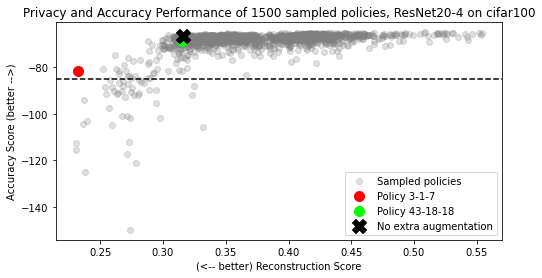

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

sample = 1500
show_baseline = True

sample_idx = list(range(len(recons)))
np.random.seed(42069)
np.random.shuffle(sample_idx)

ax.scatter(np.array(recons)[sample_idx][:sample], np.array(accs)[sample_idx][:sample], color='grey', alpha=0.25, label='Sampled policies')

colors = ["red", "lime"]
for s_rec, s_acc, name, color in zip(special_recons, special_accs, special_pols, colors):
    ax.scatter([s_rec], [s_acc], color=color, label=f"Policy {name}", s=100)

# 0.316, -66.8
if show_baseline:
    ax.scatter([0.316], [-66.8], color="black", marker='X', s=200, label='No extra augmentation')

ax.axhline(-85, ls="--", color="black")

ax.set_xlabel("(<-- better) Reconstruction Score")
ax.set_ylabel("Accuracy Score (better -->)")

ax.set_title("Privacy and Accuracy Performance of 1500 sampled policies, ResNet20-4 on cifar100")

plt.legend()
plt.savefig(f"./graphs/policy_cifar100_resnet20-4_{sample}_{show_baseline}.png")
plt.show()

In [8]:
special_pols

['3-1-7', '43-18-18']

In [9]:
special_recons

[0.23206943829599563, 0.31478065689124934]

In [10]:
list(np.argsort(special_recons))

[0, 1]

In [11]:
np.array(special_pols)[list(np.argsort(special_recons))]

array(['3-1-7', '43-18-18'], dtype='<U8')

In [12]:
top_scores = np.sort(recons)
top_pols = np.array(pols)[np.argsort(recons)]

print(f"Paper #1 {special_pols[0]} {special_recons[0]:.2f}")
print(f"Paper #2 {special_pols[1]} {special_recons[1]:.2f}")
print()

for i, p in enumerate(top_pols[:15]):
    print(f"#{i+1} {p} ({top_scores[i]:.2f})")

Paper #1 3-1-7 0.23
Paper #2 43-18-18 0.31

#1 21-19-3 (0.22)
#2 34-3-21 (0.23)
#3 21-13-3 (0.23)
#4 21-3-20 (0.23)
#5 21-7-3 (0.23)
#6 26-3-18 (0.23)
#7 11-3-1 (0.23)
#8 21-3-14 (0.24)
#9 3-7-18 (0.24)
#10 21-3-44 (0.24)
#11 3-18 (0.24)
#12 3-1-18 (0.24)
#13 3-19-1 (0.24)
#14 21-29-3 (0.24)
#15 3-30-18 (0.24)


# Combined scores

In [13]:
accuracy_folder = results_folder+'/accuracy/'+folder_name+'/'
reconstruction_folder = results_folder+'/reconstruction/'+folder_name+'/'

acc_results = defaultdict(list)
recon_results = defaultdict(list)

for i, filename in enumerate(os.listdir(accuracy_folder)):
    policy_name = filename.split(".npy")[0]
    
    acc_scores = np.load(accuracy_folder+filename).tolist()
    acc_mean = np.mean(acc_scores)
    
    recon_scores = np.load(reconstruction_folder+filename).tolist()
    recon_mean = np.mean(recon_scores)
    
    if acc_mean < -150:
        continue
    
    for idx in policy_name.split("-"):
        acc_results[int(idx)].append(acc_mean)
        recon_results[int(idx)].append(recon_mean)
        
for dic in (acc_results, recon_results):
    for key, values in dic.items():
        dic[key] = np.mean(values)

In [14]:
def sort_dic(dic):
    new_dic = {}
    for i in range(len(dic)):
        new_dic[i] = dic[i]
        
    return new_dic

acc_results = sort_dic(acc_results)
recon_results = sort_dic(recon_results)

In [15]:
def filter_dic(dic, special = [1, 3, 15, 18, 26]):
    boring_dic = {}
    special_dic = {}
    
    special_ids = []
    ids = []
    for i, (key, value) in enumerate(dic.items()):
        if key in special:
            special_dic[key] = value
            special_ids.append(i)
        else:
            boring_dic[key] = value
            ids.append(i)

    return boring_dic, special_dic, ids, special_ids

acc_results, acc_special_results, ids, special_ids = filter_dic(acc_results)
recon_results, recon_special_results, ids, special_ids = filter_dic(recon_results)

In [16]:
recon_special_results

{1: 0.3561940338971555,
 3: 0.2778534717056203,
 15: 0.3506443619579646,
 18: 0.36063955573033396,
 26: 0.3591260183365893}

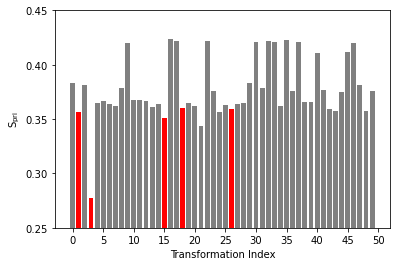

In [17]:
fig, ax = plt.subplots()

ax.bar(x=list(recon_results.keys()), height=recon_results.values(), color="grey")
ax.bar(x=list(recon_special_results.keys()), height=recon_special_results.values(), color="red")

ax.set_ylabel('$\mathregular{S_{pri}}$')
ax.set_xlabel('Transformation Index')

ax.set_xticks(range(0, 51, 5))
ax.set_yticks([0.25, 0.30, 0.35, 0.40, 0.45])

ax.set_ylim(0.25, 0.45)
# ax.set_xticks(ticks=ids+special_ids, labels=ids+special_ids)

# ax.set_title("Average Reconstruction Score of Augmentations in policy")
plt.savefig(r".\graphs\policy_reconstruction_combined.png")
plt.show()

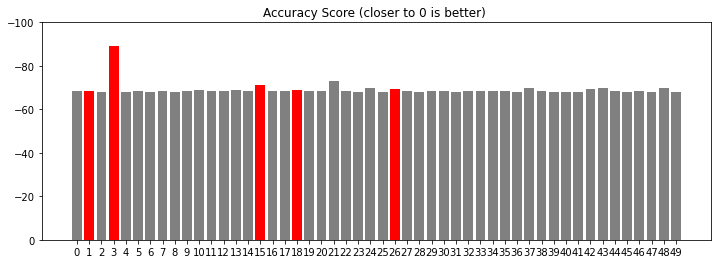

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(x=list(acc_results.keys()), height=acc_results.values(), color="grey")
ax.bar(x=list(acc_special_results.keys()), height=acc_special_results.values(), color="red")

ax.set_ylim(0, -100)

ax.set_xticks(ticks=ids+special_ids, labels=ids+special_ids)

ax.set_title("Accuracy Score (closer to 0 is better) ")

plt.show()

# Individual scores

In [19]:
results_folder = '../ATSRefactored/results_solo'

In [20]:
accuracy_folder = results_folder+'/accuracy/'+folder_name+'/'
reconstruction_folder = results_folder+'/reconstruction/'+folder_name+'/'

acc_results = defaultdict(list)
recon_results = defaultdict(list)

for i, filename in enumerate(os.listdir(accuracy_folder)):
    policy_name = filename.split(".npy")[0]
    
    acc_scores = np.load(accuracy_folder+filename).tolist()
    acc_mean = np.mean(acc_scores)
    
    recon_scores = np.load(reconstruction_folder+filename).tolist()
    recon_mean = np.mean(recon_scores)
    
    if acc_mean < -150:
        continue
    
    for idx in policy_name.split("-"):
        acc_results[int(idx)].append(acc_mean)
        recon_results[int(idx)].append(recon_mean)
        
for dic in (acc_results, recon_results):
    for key, values in dic.items():
        dic[key] = np.mean(values)

acc_results = sort_dic(acc_results)
recon_results = sort_dic(recon_results)

acc_results, acc_special_results, ids, special_ids = filter_dic(acc_results)
recon_results, recon_special_results, ids, special_ids = filter_dic(recon_results)

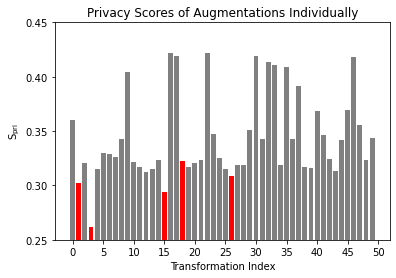

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x=list(recon_results.keys()), height=recon_results.values(), color="grey")
ax.bar(x=list(recon_special_results.keys()), height=recon_special_results.values(), color="red")

ax.set_ylabel('$\mathregular{S_{pri}}$')
ax.set_xlabel('Transformation Index')

ax.set_ylim(0.25, 0.45)
# ax.set_xticks(ticks=ids+special_ids, labels=ids+special_ids)

ax.set_xticks(range(0, 51, 5))
ax.set_yticks([0.25, 0.30, 0.35, 0.40, 0.45])

ax.set_title("Privacy Scores of Augmentations Individually")
plt.savefig(r".\graphs\policy_reconstruction_individual_fixed.png")
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.bar(x=list(recon_results.keys()), height=recon_results.values(), color="grey")
ax.bar(x=list(recon_special_results.keys()), height=recon_special_results.values(), color="red")



ax.set_ylim(0.25, 0.45)
# ax.set_xticks(ticks=ids+special_ids, labels=ids+special_ids)

# ax.set_title("Average Reconstruction Score of Augmentations in policy")
plt.show()

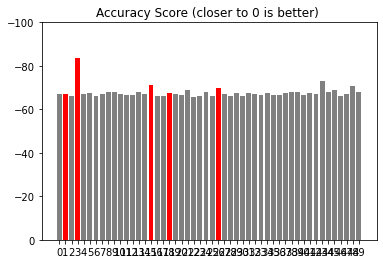

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x=list(acc_results.keys()), height=acc_results.values(), color="grey")
ax.bar(x=list(acc_special_results.keys()), height=acc_special_results.values(), color="red")

ax.set_ylim(0, -100)

ax.set_xticks(ticks=ids+special_ids, labels=ids+special_ids)

ax.set_title("Accuracy Score (closer to 0 is better) ")
plt.savefig(r".\graphs\policy_accuracy_individual.png")

plt.show()

In [23]:
top_scores = np.sort(list(recon_results.values())+list(recon_special_results.values()))
top_pols = np.array(list(recon_results.keys())+list(recon_special_results.keys()))[np.argsort(list(recon_results.values())+list(recon_special_results.values()))]

print(f"Paper #1 {special_pols[0]} {special_recons[0]:.2f}")
print(f"Paper #2 {special_pols[1]} {special_recons[1]:.2f}")
print()

for i, p in enumerate(top_pols[:100]):
    print(f"#{i+1} {p} ({top_scores[i]:.2f})")

Paper #1 3-1-7 0.23
Paper #2 43-18-18 0.31

#1 3 (0.26)
#2 15 (0.29)
#3 1 (0.30)
#4 26 (0.31)
#5 12 (0.31)
#6 43 (0.31)
#7 25 (0.31)
#8 13 (0.32)
#9 4 (0.32)
#10 39 (0.32)
#11 19 (0.32)
#12 11 (0.32)
#13 38 (0.32)
#14 34 (0.32)
#15 28 (0.32)
#16 27 (0.32)
#17 2 (0.32)
#18 20 (0.32)
#19 10 (0.32)
#20 18 (0.32)
#21 14 (0.32)
#22 21 (0.32)
#23 48 (0.32)
#24 42 (0.32)
#25 24 (0.33)
#26 7 (0.33)
#27 6 (0.33)
#28 5 (0.33)
#29 44 (0.34)
#30 8 (0.34)
#31 36 (0.34)
#32 31 (0.34)
#33 49 (0.34)
#34 41 (0.35)
#35 23 (0.35)
#36 29 (0.35)
#37 47 (0.36)
#38 0 (0.36)
#39 40 (0.37)
#40 45 (0.37)
#41 37 (0.39)
#42 9 (0.40)
#43 35 (0.41)
#44 33 (0.41)
#45 32 (0.41)
#46 46 (0.42)
#47 30 (0.42)
#48 17 (0.42)
#49 22 (0.42)
#50 16 (0.42)


# Quick Hypothese

In [24]:
results_folder = '../ATSRefactored/results'

results = []

accuracy_folder = results_folder+'/accuracy/'+folder_name+'/'
reconstruction_folder = results_folder+'/reconstruction/'+folder_name+'/'

pols, accs, recons, ids = [], [], [], []
special_pols, special_accs, special_recons, special_ids = [], [], [], []

special = ["3-1-7",
        "43-18-18"]

for i, filename in enumerate(os.listdir(accuracy_folder)):
    policy_name = filename.split(".npy")[0]
    
    acc_scores = np.load(accuracy_folder+filename).tolist()
    acc_mean = np.mean(acc_scores)
    
    recon_scores = np.load(reconstruction_folder+filename).tolist()
    recon_mean = np.mean(recon_scores)
    
    if acc_mean < -150:
        continue
    
    if policy_name in special:       
        special_pols.append(policy_name)
        special_accs.append(acc_mean)
        special_recons.append(recon_mean)
        special_ids.append(i)
    else:
        pols.append(policy_name)
        accs.append(acc_mean)
        recons.append(recon_mean)
        ids.append(i)

In [25]:
results_folder = '../ATSRefactored/results_all_perms'

results = []

accuracy_folder = results_folder+'/accuracy/'+folder_name+'/'
reconstruction_folder = results_folder+'/reconstruction/'+folder_name+'/'

ultra_pols, ultra_accs, ultra_recons, ultra_ids = [], [], [], []

for i, filename in enumerate(os.listdir(accuracy_folder)):
    policy_name = filename.split(".npy")[0]
    
    acc_scores = np.load(accuracy_folder+filename).tolist()
    acc_mean = np.mean(acc_scores)
    
    recon_scores = np.load(reconstruction_folder+filename).tolist()
    recon_mean = np.mean(recon_scores)
    
    if acc_mean < -150:
        continue
    
    ultra_pols.append(policy_name)
    ultra_accs.append(acc_mean)
    ultra_recons.append(recon_mean)
    ultra_ids.append(i)

In [26]:
ultra_accs

[-67.52412214241615,
 -66.08339167220508,
 -67.81688987677202,
 -66.14034632757712,
 -70.03765955805677,
 -69.27129968154611,
 -68.84776347628721,
 -71.06689767728821,
 -66.99195811269288,
 -68.38423669422177,
 -71.70632020561116,
 -69.95114756026132,
 -66.80653930943373,
 -67.33626780350828,
 -69.83042591052728,
 -73.00883091511548,
 -66.42354702233544,
 -69.30814858613516,
 -68.19486977083076,
 -68.0863627602587,
 -69.69841137572487,
 -68.00569909114786,
 -67.60078013871103,
 -67.75791584056745,
 -66.76271825596271,
 -66.75849173417964,
 -66.15305507527418,
 -68.32716185841153,
 -68.47579874711433,
 -71.64283159898157,
 -67.91642425370176,
 -67.51444419640288,
 -70.82728894638032,
 -77.60397348438283,
 -74.43634213651151,
 -78.48832491797882,
 -77.1083193493971,
 -73.2426202580887,
 -71.72029542585234,
 -72.65431011220171,
 -75.83825172582632,
 -71.35461086645492,
 -68.19886802659559,
 -78.44078949494106,
 -74.17035243161467,
 -72.92553443032627,
 -73.25185960389204,
 -73.07482010105

In [27]:
min(accs)

-149.75304265905407

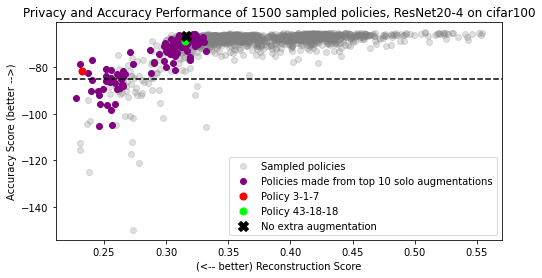

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))

sample = 1500
show_baseline = True

sample_idx = list(range(len(recons)))
np.random.seed(42069)
np.random.shuffle(sample_idx)

ax.scatter(np.array(recons)[sample_idx][:sample], np.array(accs)[sample_idx][:sample], color='grey', alpha=0.25, label='Sampled policies')

ax.scatter(ultra_recons, ultra_accs, color="purple", label='Policies made from top 10 solo augmentations')

colors = ["red", "lime"]
for s_rec, s_acc, name, color in zip(special_recons, special_accs, special_pols, colors):
    ax.scatter([s_rec], [s_acc], color=color, label=f"Policy {name}", s=50)

# 0.316, -66.8
if show_baseline:
    ax.scatter([0.316], [-66.8], color="black", marker='X', s=100, label='No extra augmentation')


ax.axhline(-85, ls="--", color="black")

ax.set_xlabel("(<-- better) Reconstruction Score")
ax.set_ylabel("Accuracy Score (better -->)")

ax.set_title("Privacy and Accuracy Performance of 1500 sampled policies, ResNet20-4 on cifar100")

plt.legend()
plt.savefig(f"./graphs/policy_cifar100_resnet20-4_ULTRA_{sample}_{show_baseline}.png")
plt.show()

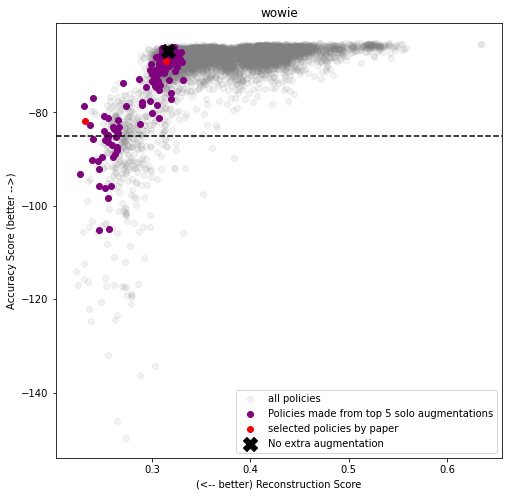

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(recons, accs, color='grey', alpha=0.1, label='all policies')

ax.scatter(ultra_recons, ultra_accs, color="purple", label='Policies made from top 5 solo augmentations')
ax.scatter(special_recons, special_accs, color="red", label='selected policies by paper')

# 0.316, -66.8
ax.scatter([0.316], [-66.8], color="black", marker='X', s=200, label='No extra augmentation')


ax.axhline(-85, ls="--", color="black")

ax.set_xlabel("(<-- better) Reconstruction Score")
ax.set_ylabel("Accuracy Score (better -->)")

ax.set_title("wowie")

plt.legend()
plt.savefig(r".\graphs\policy_cifar100_resnet20-4_enhanced.png")
plt.show()

In [30]:
np.array(ultra_pols)[np.bitwise_and((np.array(ultra_recons)<0.25), np.array(ultra_accs)>-80)]

array(['3-1-39', '3-1-4'], dtype='<U8')

In [31]:
top_scores = np.sort(ultra_recons)
top_pols = np.array(ultra_pols)[np.argsort(ultra_recons)]
top_accs = np.array(ultra_accs)[np.argsort(ultra_recons)]

print(f"Paper #1 {special_pols[0]} ({special_recons[0]:.2f}) ({special_accs[0]:.2f})")
print(f"Paper #2 {special_pols[1]} ({special_recons[1]:.2f}) ({special_accs[1]:.2f})")
print()

print("Best out of perms of top 10:")
for i, p in enumerate(top_pols[:120]):
    print(f"#{i+1} {p} ({top_scores[i]:.2f}) ({top_accs[i]:.2f})")

Paper #1 3-1-7 (0.23) (-81.90)
Paper #2 43-18-18 (0.31) (-68.89)

Best out of perms of top 10:
#1 3-15-1 (0.23) (-93.19)
#2 3-1-4 (0.23) (-78.60)
#3 3-1-12 (0.24) (-82.62)
#4 3-1-26 (0.24) (-90.29)
#5 3-1-39 (0.24) (-76.95)
#6 3-1-25 (0.24) (-85.72)
#7 3-1-43 (0.25) (-90.33)
#8 3-15-12 (0.25) (-92.08)
#9 3-15-4 (0.25) (-105.26)
#10 3-15-26 (0.25) (-95.84)
#11 3-26-43 (0.25) (-89.54)
#12 3-43-4 (0.25) (-80.82)
#13 3-26-13 (0.25) (-84.03)
#14 3-26-39 (0.25) (-85.86)
#15 3-15-25 (0.25) (-96.21)
#16 3-25-13 (0.25) (-86.42)
#17 3-1-13 (0.25) (-85.32)
#18 3-15-39 (0.26) (-98.42)
#19 3-26-25 (0.26) (-84.92)
#20 3-13-39 (0.26) (-81.18)
#21 3-15-13 (0.26) (-105.01)
#22 3-43-13 (0.26) (-95.75)
#23 3-26-12 (0.26) (-86.91)
#24 3-43-25 (0.26) (-83.18)
#25 3-13-4 (0.26) (-89.56)
#26 3-25-39 (0.26) (-83.56)
#27 3-4-39 (0.26) (-88.90)
#28 3-15-43 (0.26) (-85.25)
#29 3-43-39 (0.26) (-84.11)
#30 3-26-4 (0.26) (-87.31)
#31 3-25-4 (0.27) (-88.13)
#32 3-12-13 (0.27) (-81.69)
#33 3-12-39 (0.27) (-84.43)
#34